In [8]:
import os

os.chdir('/Users/soniaqi/Documents/QBio-490/qbio_490_sonia/final_project')

# import necessary libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

In [3]:
# Import cptac
import cptac
# Examine the data sets available with list_datasets()
cptac.list_datasets()

,Description,Data reuse status,Publication link
Dataset name,,,
Brca,breast cancer,no restrictions,https://pubmed.ncbi.nlm.nih.gov/33212010/
Ccrcc,clear cell renal cell carcinoma (kidney),no restrictions,https://pubmed.ncbi.nlm.nih.gov/31675502/
Colon,colorectal cancer,no restrictions,https://pubmed.ncbi.nlm.nih.gov/31031003/
Endometrial,endometrial carcinoma (uterine),no restrictions,https://pubmed.ncbi.nlm.nih.gov/32059776/
Gbm,glioblastoma,no restrictions,https://pubmed.ncbi.nlm.nih.gov/33577785/
Hnscc,head and neck squamous cell carcinoma,no restrictions,https://pubmed.ncbi.nlm.nih.gov/33417831/
Lscc,lung squamous cell carcinoma,no restrictions,https://pubmed.ncbi.nlm.nih.gov/34358469/
Luad,lung adenocarcinoma,no restrictions,https://pubmed.ncbi.nlm.nih.gov/32649874/
Ovarian,high grade serous ovarian cancer,no restrictions,https://pubmed.ncbi.nlm.nih.gov/27372738/


In [4]:
# Download the colon cancer data set
cptac.download(dataset="Colon")
colon = cptac.Colon()

In [5]:
colon.list_data()

Below are the dataframes contained in this dataset and their dimensions:

clinical
	210 rows
	17 columns
CNV
	105 rows
	25187 columns
derived_molecular
	110 rows
	11 columns
followup
	205 rows
	71 columns
miRNA
	105 rows
	989 columns
phosphoproteomics
	197 rows
	31339 columns
proteomics
	197 rows
	8067 columns
somatic_mutation
	93717 rows
	3 columns
somatic_mutation_binary
	106 rows
	86026 columns
transcriptomics
	106 rows
	13482 columns


In [5]:
protein_data = colon.get_proteomics() # get the proteomics data
protein_data = protein_data.drop_duplicates()
protein_data.columns = protein_data.columns.get_level_values(0) 
protein_data.index = protein_data.index.get_level_values(0) 

rna_data = colon.get_transcriptomics() # get the transcriptomics data
rna_data = rna_data.drop_duplicates()
rna_data.columns = rna_data.columns.get_level_values(0) 
rna_data.index = rna_data.index.get_level_values(0) 

clinical_data = colon.get_clinical() # get the clinical data
mutation_data = colon.get_somatic_mutation() # get the mutation data

In [6]:
# remove potential duplication
rna_data = rna_data.dropna(axis=1)
protein_data = protein_data.dropna(axis=1)

In [9]:
# adding columns with helpful information
clinical_data["Age_in_year"] = clinical_data["Age"]/12
clinical_data["diagnos_status"] = np.where(clinical_data["Age_in_year"]<=50, "Early Onset", "Late Onset")

In [10]:
# get data from patients with tumor
tumor_mask = clinical_data["Sample_Tumor_Normal"]=="Tumor"
clinical_data = clinical_data[tumor_mask]

In [22]:
early_mask = np.where(clinical_data["diagnos_status"]=="Early Onset")
early_data = clinical_data.iloc[early_mask]
late_mask = np.where(clinical_data["diagnos_status"]=="Late Onset")
late_data = clinical_data.iloc[late_mask]

In [25]:
early_rna_mask = np.intersect1d(early_data.index, rna_data.index)
early_rna = rna_data.loc[early_rna_mask, :]
early_prot_mask = np.intersect1d(early_data.index, protein_data.index)
early_prot = protein_data.loc[early_prot_mask, :]
# patients in early_rna and early_prot overlap completely, so no adjustments needed

late_rna_mask = np.intersect1d(late_data.index, rna_data.index)
late_rna = rna_data.loc[late_rna_mask, :]
late_prot_mask = np.intersect1d(late_data.index, protein_data.index)
late_prot = protein_data.loc[late_prot_mask, :]

# make sure patients are share in rna and protein
late_rna_prot = np.intersect1d(late_rna.index, late_prot.index)
late_rna = rna_data.loc[late_rna_prot, :]
late_prot = protein_data.loc[late_rna_prot, :]

In [26]:
# select only genes share in rna and protein datasets
shared_rna_prot = np.intersect1d(rna_data.columns, protein_data.columns)

early_rna_shared = early_rna.loc[:, shared_rna_prot]
early_prot_shared = early_prot.loc[:, shared_rna_prot]
late_rna_shared = late_rna.loc[:, shared_rna_prot]
late_prot_shared = late_prot.loc[:, shared_rna_prot]

In [27]:
# find the most mutated genes with available in both omics
share_mutation = mutation_data.loc[mutation_data['Gene'].isin(shared_rna_prot)] 
mutation_counts = share_mutation['Gene'].value_counts()
high_mutation = mutation_counts.index.tolist()

In [30]:
early_rna_shared

Name,A2M,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARS,AARS2,...,ZNF22,ZNF326,ZNF512,ZNF622,ZNF638,ZPR1,ZRANB2,ZW10,ZYX,ZZEF1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
05CO011,13.2824,9.8376,8.9858,10.3015,9.6129,7.1799,11.1892,10.6591,11.3767,8.9972,...,8.3750,10.8009,9.8234,10.2180,11.7026,9.5699,11.0888,9.3421,10.6760,10.2527
11CO036,12.2273,9.8154,9.4094,10.9744,8.6970,8.4429,11.6843,10.0098,11.5401,8.7074,...,10.5670,10.2155,9.5098,10.1687,11.9922,10.7065,11.0341,9.9396,10.3287,9.4179
11CO061,12.0570,9.8281,9.3242,11.7202,6.4757,8.2336,10.5641,10.0485,10.4808,8.2808,...,10.3365,10.6680,9.0028,10.0168,12.6702,10.8321,11.9622,10.5840,8.0607,7.9009
11CO070,13.0007,9.5488,9.0279,11.1898,9.0362,8.0928,11.3309,9.7863,11.0815,8.6546,...,10.1228,10.5048,9.5118,9.4818,11.9451,10.7228,11.4676,9.6636,10.8025,9.5469
21CO007,13.4762,9.6018,9.1573,10.9159,10.9315,8.0980,11.5333,10.8106,11.3426,9.3945,...,10.1163,10.2384,9.5058,10.0265,11.8478,10.7541,10.9866,10.1293,9.4136,9.7245
24CO005,13.0250,10.2228,9.3729,11.0566,8.0980,9.5641,11.0868,11.2252,10.8842,8.3443,...,11.0161,10.2082,8.9571,9.8580,11.9897,11.0334,11.4273,9.8933,8.3264,7.8704


In [ ]:
there should be 8 rows

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 6 and the array at index 1 has size 5

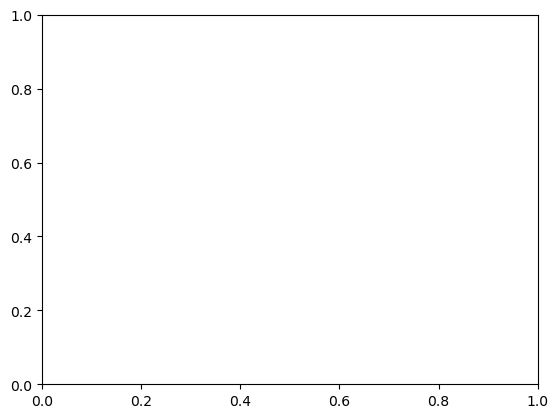

In [29]:
# set top20 mutated genes as the target
gene_names = high_mutation[:20]
ncomparisons = 20

# create heatmap for female early onset
fig, ax = plt.subplots()
corr_df = pd.DataFrame(np.ndarray(shape=(ncomparisons, ncomparisons), dtype=np.float16),
                      index = gene_names,
                      columns = gene_names)
for g1 in gene_names:
    for g2 in gene_names:
        # calculate the correlations between protein and RNA
        corr, pval = stats.spearmanr(early_rna_shared[g1], early_prot_shared[g2], nan_policy = 'omit')
        corr_df.loc[g1, g2] = corr
plot = sns.heatmap(
    corr_df,
    cmap='mako',
    ax = ax
)
fig.suptitle('Early Onset')
plot.set_xlabel('Protein', fontsize=10)
plot.set_ylabel('RNA', fontsize=10)
plt.savefig('early.png', bbox_inches='tight')

In [11]:
# create separate dataset for both genders
female_mask = np.where(clinical_data["Gender"]=="Female")
female_clinical_data = clinical_data.iloc[female_mask]
male_mask = np.where(clinical_data["Gender"]=="Male")
male_clinical_data = clinical_data.iloc[male_mask]

In [12]:
# create separate dataset for early and late onset
female_early_mask = np.where(female_clinical_data["diagnos_status"]=="Early Onset")
female_early_data = clinical_data.iloc[female_early_mask]
female_late_mask = np.where(female_clinical_data["diagnos_status"]=="Late Onset")
female_late_data = clinical_data.iloc[female_late_mask]

In [13]:
# create separate dataset for early and late onset
male_early_mask = np.where(male_clinical_data["diagnos_status"]=="Early Onset")
male_early_data = clinical_data.iloc[male_early_mask]
male_late_mask = np.where(male_clinical_data["diagnos_status"]=="Late Onset")
male_late_data = clinical_data.iloc[male_late_mask]

In [14]:
# create separate rna and protein dataset for female early, female late, male early, and male late
fe_rna_mask = np.intersect1d(female_early_data.index, rna_data.index)
fe_rna = rna_data.loc[fe_rna_mask, :]
fe_prot_mask = np.intersect1d(female_early_data.index, protein_data.index)
fe_prot = protein_data.loc[fe_prot_mask, :]
# patients in fe_rna and fe_prot overlap completely, so no adjustments needed

fl_rna_mask = np.intersect1d(female_late_data.index, rna_data.index)
fl_rna = rna_data.loc[fl_rna_mask, :]
fl_prot_mask = np.intersect1d(female_late_data.index, protein_data.index)
fl_prot = protein_data.loc[fl_prot_mask, :]
# make sure patients are share in rna and protein
fl_rna_prot = np.intersect1d(fl_rna.index, fl_prot.index)
fl_rna = rna_data.loc[fl_rna_prot, :]
fl_prot = protein_data.loc[fl_rna_prot, :]

me_rna_mask = np.intersect1d(male_early_data.index, rna_data.index)
me_rna = rna_data.loc[me_rna_mask, :]
me_prot_mask = np.intersect1d(male_early_data.index, protein_data.index)
me_prot = protein_data.loc[me_prot_mask, :]
# patients in me_rna and me_prot overlap completely, so no adjustments needed

ml_rna_mask = np.intersect1d(male_late_data.index, rna_data.index)
ml_rna = rna_data.loc[ml_rna_mask, :]
ml_prot_mask = np.intersect1d(male_late_data.index, protein_data.index)
ml_prot = protein_data.loc[ml_prot_mask, :]
# make sure patients are share in rna and protein
ml_rna_prot = np.intersect1d(ml_rna.index, ml_prot.index)
ml_rna = rna_data.loc[ml_rna_prot, :]
ml_prot = protein_data.loc[ml_rna_prot, :]

In [15]:
# select only genes share in rna and protein datasets
shared_rna_prot = np.intersect1d(rna_data.columns, protein_data.columns)

fe_rna_shared = fe_rna.loc[:, shared_rna_prot]
fe_prot_shared = fe_prot.loc[:, shared_rna_prot]
fl_rna_shared = fl_rna.loc[:, shared_rna_prot]
fl_prot_shared = fl_prot.loc[:, shared_rna_prot]

me_rna_shared = me_rna.loc[:, shared_rna_prot]
me_prot_shared = me_prot.loc[:, shared_rna_prot]
ml_rna_shared = ml_rna.loc[:, shared_rna_prot]
ml_prot_shared = ml_prot.loc[:, shared_rna_prot]

In [16]:
# find the most mutated genes with available in both omics
share_mutation = mutation_data.loc[mutation_data['Gene'].isin(shared_rna_prot)] 
mutation_counts = share_mutation['Gene'].value_counts()
high_mutation = mutation_counts.index.tolist()

In [21]:
ml_prot_shared

Name,A2M,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARS,AARS2,...,ZNF22,ZNF326,ZNF512,ZNF622,ZNF638,ZPR1,ZRANB2,ZW10,ZYX,ZZEF1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
01CO005,-0.487,0.0995,0.1550,0.1690,0.0653,-0.1470,0.1140,0.3410,-0.1090,0.1230,...,-0.0656,-0.1000,0.5380,-0.1380,0.2420,0.0221,0.2500,0.0869,-0.7330,-0.2650
01CO006,-0.347,-0.0029,0.0957,0.3960,-0.0363,-0.5490,0.2200,0.2480,-0.0172,0.2200,...,-0.2180,-0.0430,0.1860,0.0274,0.2400,-0.3940,0.0846,0.0010,-0.6580,0.0052
01CO008,-1.850,0.1190,-0.0924,0.0187,-0.2140,0.3280,-0.2820,-0.3480,-0.6240,-0.6280,...,-0.7150,0.4320,-0.8070,0.2450,0.3150,-0.1680,0.3570,-0.3250,-0.8210,0.2000
01CO013,-0.329,0.6700,0.1160,0.3130,-0.2380,-0.2740,-0.5540,0.2700,-0.1890,0.3090,...,-0.1050,0.3080,-0.5090,0.3850,0.3260,-0.0656,-0.2950,0.4630,-0.9040,-0.1580
01CO015,-0.976,0.5220,-0.2730,0.5040,-0.3180,-0.8460,0.2000,0.5300,0.0262,0.1050,...,-0.1250,0.4260,-0.9400,0.5140,0.1950,-0.0554,0.4370,0.0566,-0.2580,-0.3430
01CO019,-0.921,0.2260,0.0528,0.0428,-0.0620,-0.1240,0.0779,0.1110,-0.0269,-0.2260,...,-0.4960,0.1760,-0.6020,0.3780,-0.0898,0.4610,0.0694,-0.0826,0.0425,-0.2690
01CO022,1.450,0.3590,0.2190,0.7710,-0.0471,-0.9160,0.4770,0.2160,0.2650,-0.0087,...,-0.1260,0.0279,-0.3590,0.0701,0.1820,0.1940,0.1740,0.2990,-0.6200,-0.7180
05CO002,-1.370,0.0167,0.2120,-0.0213,-0.1430,-0.9580,0.0682,0.2390,-0.0054,-0.4410,...,0.1440,0.4110,-0.4590,0.1760,0.1260,0.4770,0.1270,-0.2070,-0.6760,-0.4140
05CO003,-0.438,0.8280,-0.0137,0.2960,-0.0302,-1.2100,0.1550,-0.4910,0.0323,0.1750,...,0.3160,-0.6670,0.2210,-0.2530,-0.1250,0.1040,-0.1330,-0.1020,-0.0430,-0.2430


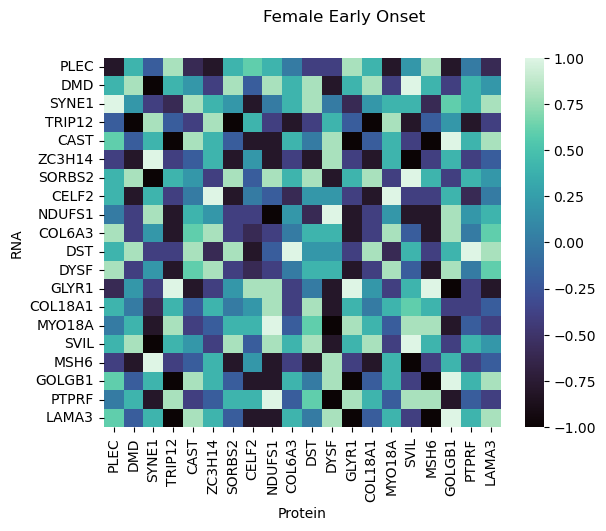

In [19]:
# set top20 mutated genes as the target
gene_names = high_mutation[:20]
ncomparisons = 20

# create heatmap for female early onset
fig, ax = plt.subplots()
corr_df = pd.DataFrame(np.ndarray(shape=(ncomparisons, ncomparisons), dtype=np.float16),
                      index = gene_names,
                      columns = gene_names)
for g1 in gene_names:
    for g2 in gene_names:
        # calculate the correlations between protein and RNA
        corr, pval = stats.spearmanr(fe_rna_shared[g1], fe_prot_shared[g2], nan_policy = 'omit')
        corr_df.loc[g1, g2] = corr
plot = sns.heatmap(
    corr_df,
    cmap='mako',
    ax = ax
)
fig.suptitle('Female Early Onset')
plot.set_xlabel('Protein', fontsize=10)
plot.set_ylabel('RNA', fontsize=10)
plt.savefig('female_early.png', bbox_inches='tight')

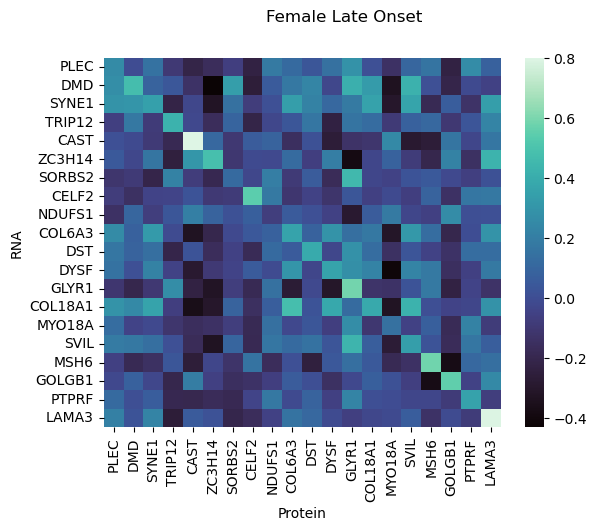

In [20]:
gene_names = high_mutation[:20]
ncomparisons = 20

# create heatmap for female late onset
fig, ax = plt.subplots()
corr_df = pd.DataFrame(np.ndarray(shape=(ncomparisons, ncomparisons), dtype=np.float16),
                      index = gene_names,
                      columns = gene_names)
for g1 in gene_names:
    for g2 in gene_names:
        # calculate the correlations between protein and RNA
        corr, pval = stats.spearmanr(fl_rna_shared[g1], fl_prot_shared[g2], nan_policy = 'omit')
        corr_df.loc[g1, g2] = corr
plot = sns.heatmap(
    corr_df,
    cmap='mako',
    ax = ax
)
fig.suptitle('Female Late Onset')
plot.set_xlabel('Protein', fontsize=10)
plot.set_ylabel('RNA', fontsize=10)
plt.savefig('female_late.png', bbox_inches='tight')

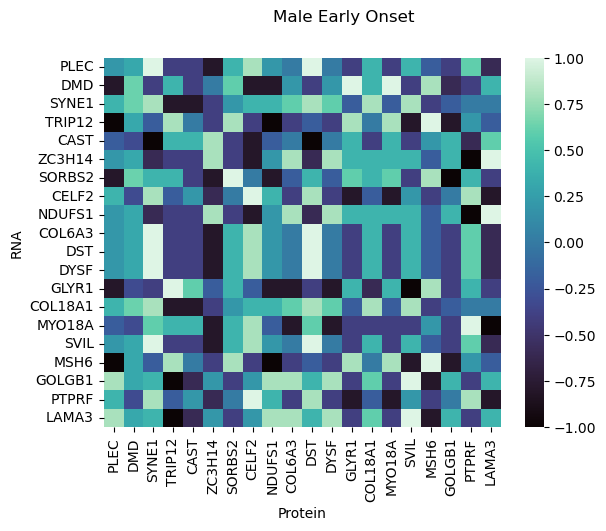

In [21]:
gene_names = high_mutation[:20]
ncomparisons = 20

# create heatmap for male early onset
fig, ax = plt.subplots()
corr_df = pd.DataFrame(np.ndarray(shape=(ncomparisons, ncomparisons), dtype=np.float16),
                      index = gene_names,
                      columns = gene_names)
for g1 in gene_names:
    for g2 in gene_names:
        # calculate the correlations between protein and RNA
        corr, pval = stats.spearmanr(me_rna_shared[g1], me_prot_shared[g2], nan_policy = 'omit')
        corr_df.loc[g1, g2] = corr
plot = sns.heatmap(
    corr_df,
    cmap='mako',
    ax = ax
)
fig.suptitle('Male Early Onset')
plot.set_xlabel('Protein', fontsize=10)
plot.set_ylabel('RNA', fontsize=10)
plt.savefig('male_early.png', bbox_inches='tight')

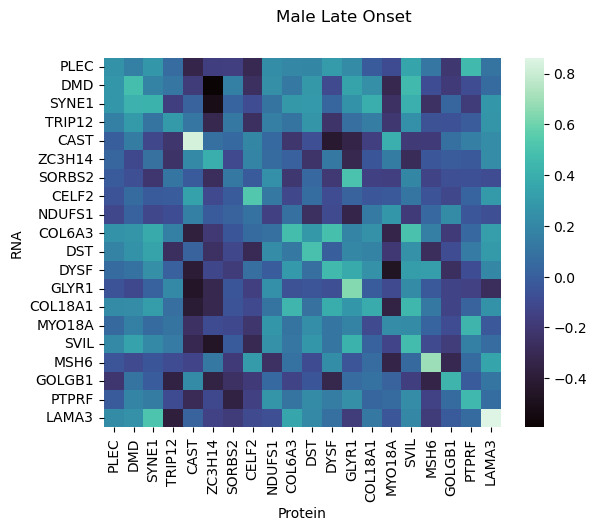

In [22]:
gene_names = high_mutation[:20]
ncomparisons = 20

# create heatmap for male late onset
fig, ax = plt.subplots()
corr_df = pd.DataFrame(np.ndarray(shape=(ncomparisons, ncomparisons), dtype=np.float16),
                      index = gene_names,
                      columns = gene_names)
for g1 in gene_names:
    for g2 in gene_names:
        # calculate the correlations between protein and RNA
        corr, pval = stats.spearmanr(ml_rna_shared[g1], ml_prot_shared[g2], nan_policy = 'omit')
        corr_df.loc[g1, g2] = corr
plot = sns.heatmap(
    corr_df,
    cmap='mako',
    ax = ax
)
fig.suptitle('Male Late Onset')
plot.set_xlabel('Protein', fontsize=10)
plot.set_ylabel('RNA', fontsize=10)
plt.savefig('male_late.png', bbox_inches='tight')